# Import

In [1]:
# generic
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
import time

# custom
import obj
import processing

# Toggles

In [2]:
is_kernel = False
is_conv = False
is_fft = True
is_ct = True

# Helper

In [3]:
def fuzz(image, ranges, p=0.15):
    rows, cols = image.shape
    for row in range(rows):
        for col in range(cols):
            if(np.random.uniform() < p):
                image[row][col] += np.random.randint(-ranges, ranges)

In [4]:
# vectorized
def magnitude(cimage):
    return np.sqrt(np.power(cimage.re, 2) + np.power(cimage.im, 2))

def logTransform(spectrum):
    return np.log10(spectrum)

# Setup

Image size:  (128, 128)


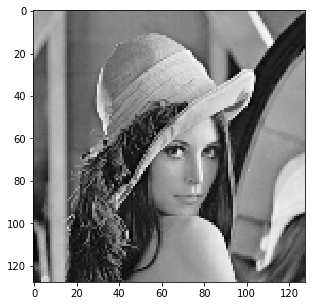

In [5]:
if is_fft or is_conv or is_kernel:
    test_path = './test.png'
    size = 128
    img = obj.Image(test_path, size)
    print("Image size: ", img.data.shape)
    plt.rcParams["figure.figsize"] = (5,5)
    plt.imshow(img.data, cmap ='gray')

# Shift Test

Quickshift Time: 0.0001418590545654297
Copy Shift Time: 0.018457889556884766
Inpl Shift Time: 0.014920949935913086


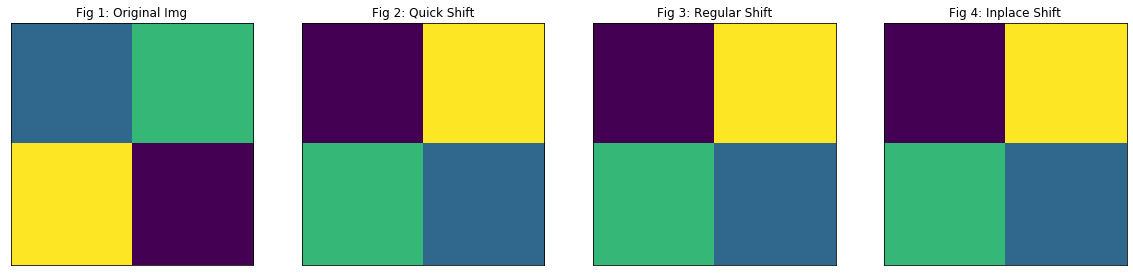

In [6]:
dummy_img = obj.Image(test_path, size)
dummy_img2 = obj.Image(test_path, size)
dummy_img3 = obj.Image(test_path, size)
quad = size // 2
dummy_img.data[quad:, quad:] = 10
dummy_img.data[:quad, :quad] = 20
dummy_img.data[:quad, quad:] = 30
dummy_img.data[quad:, :quad] = 40
dummy_img3.data[quad:, quad:] = 10
dummy_img3.data[:quad, :quad] = 20
dummy_img3.data[:quad, quad:] = 30
dummy_img3.data[quad:, :quad] = 40

t0 = time.time()
quick_shift = processing.quickShift(dummy_img.data)
t1 = time.time()
print("Quickshift Time:", t1-t0)
t0 = time.time()
processing.shift(dummy_img, dummy_img2, inplace=False)
t1 = time.time()
print("Copy Shift Time:", t1-t0)
t0 = time.time()
processing.shift(dummy_img3)
t1 = time.time()
print("Inpl Shift Time:", t1-t0)

plt.rcParams["figure.figsize"] = (20,20)
plt.subplot(141), plt.imshow(dummy_img.data)
plt.title("Fig 1: Original Img"), plt.xticks([]), plt.yticks([])
plt.subplot(142), plt.imshow(quick_shift)
plt.title("Fig 2: Quick Shift"), plt.xticks([]), plt.yticks([])
plt.subplot(143), plt.imshow(dummy_img2.data)
plt.title("Fig 3: Regular Shift"), plt.xticks([]), plt.yticks([])
plt.subplot(144), plt.imshow(dummy_img3.data)
plt.title("Fig 4: Inplace Shift"), plt.xticks([]), plt.yticks([])
plt.show()  

# Kernel Test

In [7]:
if is_kernel:
    # create ad populate kernel
    kernel = obj.Kernel(3)
    kernel.generateFilter(0.87)

    print("Generated Filter")
    print(kernel.data)
    print("Sum:", np.sum(kernel.data))
    print('\n')
    print("Pretty Generated Filter")
    print(kernel.data / np.min(kernel.data))
    print("Sum:", np.sum(kernel.data))

# Convolution Test

In [8]:
if is_conv:   
    img_in = obj.Image(test_path, size)
    img_out = obj.Image(test_path, size)
    img_out.clear()

    processing.convolve(img_in, img_out, kernel)

    plt.rcParams["figure.figsize"] = (15,15)
    plt.subplot(121), plt.imshow(img_in.data, cmap='gray')
    plt.title("Fig 1: Original Image"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(img_out.data,  cmap='gray')
    plt.title("Fig 2: Smoothed Image"), plt.xticks([]), plt.yticks([])
    plt.show()
    
    print(img_out.data.min(), img_out.data.max())

# Fourier Test

In [9]:
if is_fft:
    cimg_in = obj.CImage(test_path, size)
    cimg_out = obj.CImage(test_path, size)
    img_rev = obj.Image(test_path, size)
    img_rev.clear()

    if is_ct:
        processing.ct_fft(cimg_out)
    else:
        cimg_out.clear()
        processing.fft(cimg_in, cimg_out)

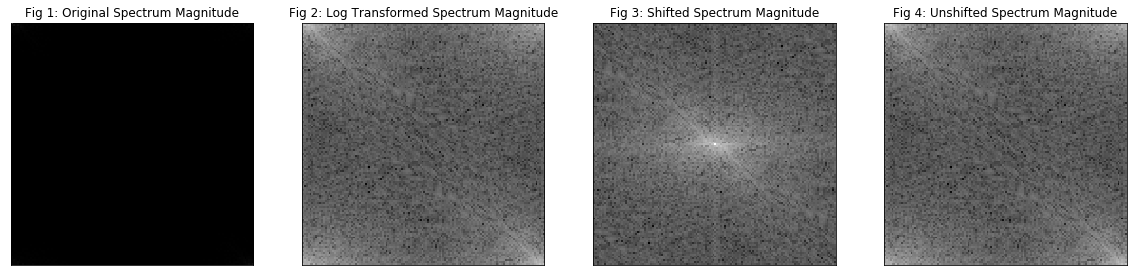

In [10]:
if is_fft:
    spectrum = magnitude(cimg_out)
    scale_spectrum = logTransform(spectrum)
    shift_spectrum = processing.quickShift(scale_spectrum)
    unshift_spectrum = processing.quickShift(shift_spectrum)
    
    plt.rcParams["figure.figsize"] = (20,20)
    plt.subplot(141), plt.imshow(spectrum, cmap='gray')
    plt.title("Fig 1: Original Spectrum Magnitude"), plt.xticks([]), plt.yticks([])
    plt.subplot(142), plt.imshow(scale_spectrum,  cmap='gray')
    plt.title("Fig 2: Log Transformed Spectrum Magnitude"), plt.xticks([]), plt.yticks([])
    plt.subplot(143), plt.imshow(shift_spectrum,  cmap='gray')
    plt.title("Fig 3: Shifted Spectrum Magnitude"), plt.xticks([]), plt.yticks([])
    plt.subplot(144), plt.imshow(unshift_spectrum,  cmap='gray')
    plt.title("Fig 4: Unshifted Spectrum Magnitude"), plt.xticks([]), plt.yticks([])
    plt.show()

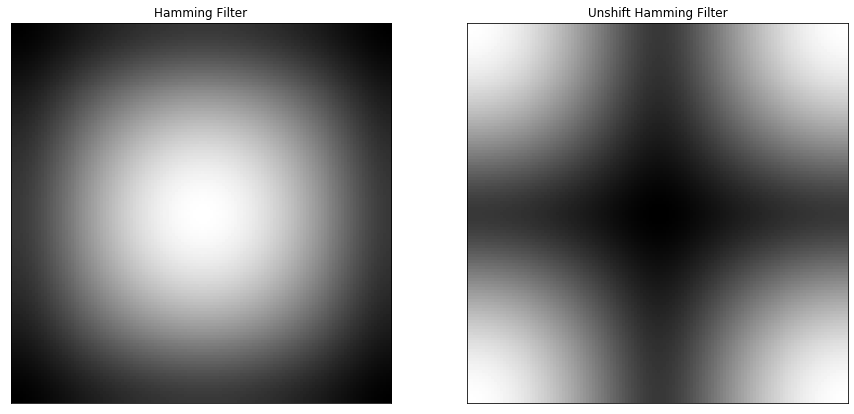

In [11]:
if is_fft:
    c_filter = obj.Hamming(size)
    c_filter.generateFilter(1)
    
    #sharpen
    #c_filter.data = np.abs(c_filter.data - 1)
    
    shift_filter = processing.quickShift(c_filter.data)
    
    plt.rcParams["figure.figsize"] = (15,15)
    plt.subplot(121),plt.imshow(c_filter.data, cmap='gray')
    plt.title("Hamming Filter"), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(shift_filter, cmap='gray')
    plt.title("Unshift Hamming Filter"), plt.xticks([]), plt.yticks([])
    plt.show()

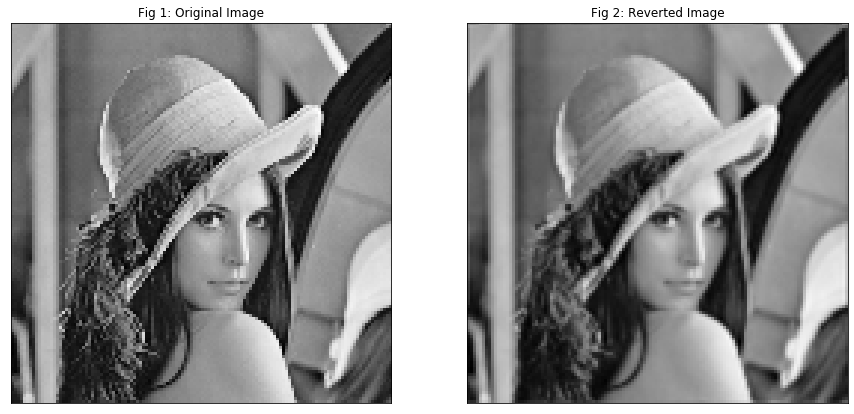

47.29949 229.12605


In [12]:
if is_fft:
    c_filter.data = shift_filter
    processing.lowpass(cimg_out, c_filter)
    
    if is_ct:
        img_revp = obj.CImage(test_path, size)
        img_revp.re = copy(cimg_out.re)
        img_revp.im = copy(cimg_out.im)
        processing.ct_ifft(img_revp)
        img_rev.data = copy(img_revp.re)
        
    else:
        processing.ifft(cimg_out, img_rev)

    plt.rcParams["figure.figsize"] = (15,15)
    plt.subplot(121), plt.imshow(cimg_in.re, cmap='gray')
    plt.title("Fig 1: Original Image"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(img_rev.data,  cmap='gray')
    plt.title("Fig 2: Reverted Image"), plt.xticks([]), plt.yticks([])
    plt.show()
    
    print(img_rev.data.min(), img_rev.data.max())